In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
import time
# Downloading NLTK data files
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load dataset
data = pd.read_csv('facts_opinions.csv')

# Initialize stop-words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) >= 3]
    return ' '.join(tokens)

# Apply preprocessing
data['Processed_Text'] = data['Text'].apply(preprocess_text)

Using device: cuda


In [ ]:
# Determine data splits
train_texts, val_texts, train_labels, val_labels, train_original_texts, val_original_texts = train_test_split(
    data['Processed_Text'].tolist(),
    data['Label'].tolist(),
    data['Text'].tolist(),
    test_size=0.1,
    random_state=42
)

In [ ]:
# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained('lighteternal/fact-or-opinion-xlmr-el')

# Tokenize the text data
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=256
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=256
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
class FactOpinionDataset(Dataset):
    def __init__(self, encodings, labels, original_texts=None):
        self.encodings = encodings
        self.labels = labels
        self.original_texts = original_texts  # For analysis purposes

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Convert labels to tensor
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.original_texts:
            item['original_text'] = self.original_texts[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = FactOpinionDataset(train_encodings, train_labels, original_texts=train_original_texts)
val_dataset = FactOpinionDataset(val_encodings, val_labels, original_texts=val_original_texts)

In [ ]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('lighteternal/fact-or-opinion-xlmr-el')
model.to(device)

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
# Defining optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Use CrossEntropyLoss for classification since model outputs logits
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

<ipython-input-15-96dab1bd1f82>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-15-96dab1bd1f82>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3, Training Loss: 0.0495, Time: 302.51s
Epoch 1/3, Validation Loss: 0.0350, Time: 21.95s
Validation Accuracy: 0.9856, Precision: 0.9729, Recall: 0.9973, F1 Score: 0.9849


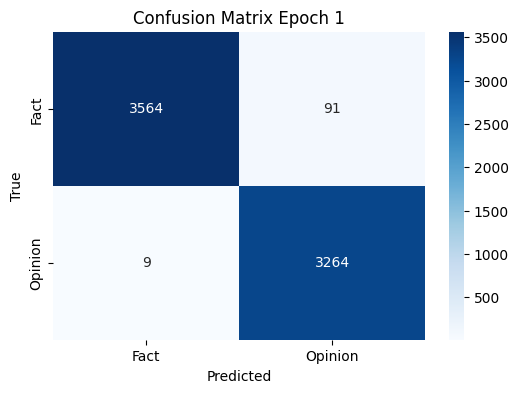

Top 10 n-grams in Misclassified Examples (Epoch 1):
the: 609
and: 341
of: 334
to: 226
in: 198
is: 189
this: 124
it: 100
for: 86
that: 83


<ipython-input-15-96dab1bd1f82>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/3, Training Loss: 0.0330, Time: 299.61s
Epoch 2/3, Validation Loss: 0.0333, Time: 29.85s
Validation Accuracy: 0.9896, Precision: 0.9886, Recall: 0.9894, F1 Score: 0.9890


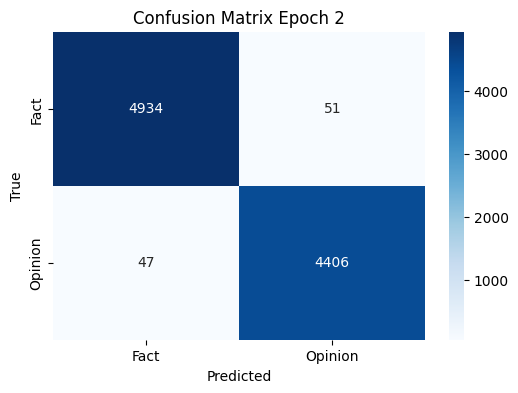

Top 10 n-grams in Misclassified Examples (Epoch 2):
the: 590
and: 336
of: 334
to: 227
in: 179
is: 158
with: 94
that: 80
this: 80
it: 79


<ipython-input-15-96dab1bd1f82>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/3, Training Loss: 0.0389, Time: 300.46s
Epoch 3/3, Validation Loss: 0.0383, Time: 28.85s
Validation Accuracy: 0.9891, Precision: 0.9882, Recall: 0.9886, F1 Score: 0.9884


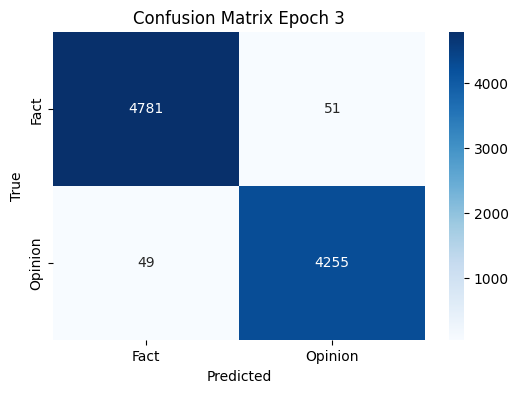

Top 10 n-grams in Misclassified Examples (Epoch 3):
the: 718
of: 396
and: 384
to: 284
in: 204
is: 179
with: 115
as: 112
that: 107
for: 103
Training complete. Final model saved as "final_model.pt".


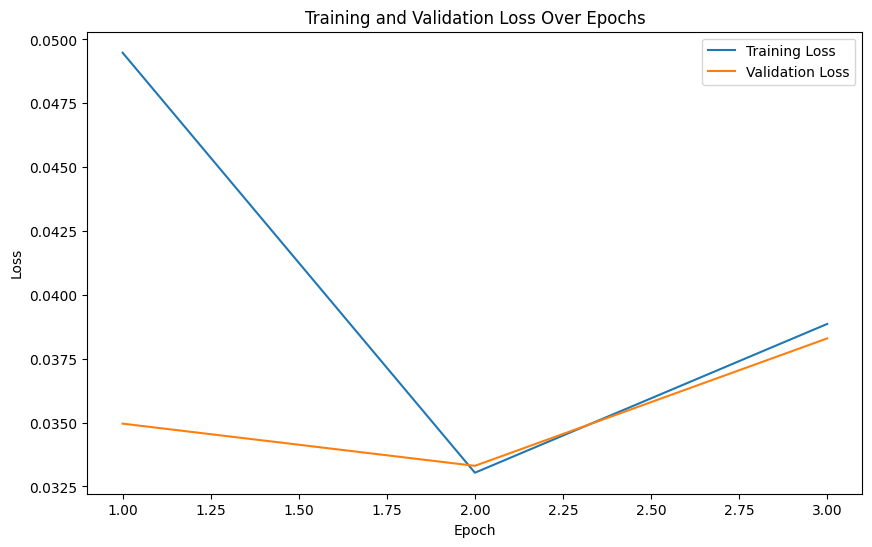

In [ ]:
epochs = 3
scaler = GradScaler()
gradient_accumulation_steps = 1
# Lists to store training and validation loss for plotting
train_losses = []
val_losses = []

# Training Loop Starts Here
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    training_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Time: {training_time:.2f}s')

    # Validation loop
    model.eval()
    val_labels_list = []
    val_preds_list = []
    val_loss = 0
    misclassified_texts = []
    misclassified_true = []
    misclassified_pred = []

    start_time = time.time()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            originals = batch.get('original_text', [])

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_labels_list.extend(labels.cpu().numpy())
            val_preds_list.extend(preds.cpu().numpy())

            # Identify misclassified examples with a limit
            for i in range(len(labels)):
                if preds[i].item() != labels[i].item():
                    misclassified_texts.append(originals[i])
                    misclassified_true.append(labels[i].item())
                    misclassified_pred.append(preds[i].item())
                    if len(misclassified_texts) >= 100:  # Limit to 100 misclassifications
                        break
            if len(misclassified_texts) >= 100:
                break

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    validation_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Time: {validation_time:.2f}s')

    # Calculate evaluation metrics
    accuracy = accuracy_score(val_labels_list, val_preds_list)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels_list, val_preds_list, average='binary'
    )
    print(
        f'Validation Accuracy: {accuracy:.4f}, '
        f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}'
    )

    # Confusion Matrix
    cm = confusion_matrix(val_labels_list, val_preds_list)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fact', 'Opinion'], yticklabels=['Fact', 'Opinion'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix Epoch {epoch + 1}')
    plt.show()

    # N-gram Analysis on Misclassified Examples
    if misclassified_texts:
        vectorizer = CountVectorizer(ngram_range=(1,2), max_features=10)  # Reduced max_features
        X = vectorizer.fit_transform(misclassified_texts)
        ngram_counts = np.array(X.sum(axis=0)).flatten()
        ngrams = vectorizer.get_feature_names_out()
        ngram_freq = sorted(zip(ngrams, ngram_counts), key=lambda x: x[1], reverse=True)

        print(f'Top 10 n-grams in Misclassified Examples (Epoch {epoch + 1}):')
        for ngram, count in ngram_freq[:10]:
            print(f'{ngram}: {count}')
    else:
        print('No misclassified examples in this epoch.')

# Load the best model
torch.save(model.state_dict(), 'final_model.pt')
print('Training complete. Final model saved as "final_model.pt".')

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()